In [2]:
try:
    import pennylane as qml
    from pennylane import numpy as np
except ImportError:
    %pip install pennylane
    import pennylane as qml
    from pennylane import numpy as np

import matplotlib.pyplot as plt

from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error 
from qiskit_aer import AerSimulator
import qiskit

from qiskit.circuit.quantumcircuit import _compare_parameters as cp

from scipy.optimize import minimize

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
TOKEN = next[:len(next)-1]
next = f.readline()
print(qml.default_config)
f.close()


In [3]:
# Setting hyper-parameters of the model: high-level parameters that determine the system we are solving

n_qubits = 3 
n_shots = 10 ** 6
tot_qubits = n_qubits + 1
ancilla_indx = n_qubits # We are using the last qubit to be the ancilla here
steps = 50 # Number of optimization steps
eta = 0.8 # "Learning rate" which is a hyperparameter that is essentially a coefficient attached to the cost 
                # sort of determines what percentage of the optimization of parameters make an effect
q_delta = 0.001 # Initial spread of random quantum weights 
rng_seed = 0 # Seed for random number generator



In [4]:
# Creating the backend and noisemodels 

# Define the basic gate set (1- and 2-qubit gates)
one_qubit_gates = ["x", "h", "s", "sdg", "ry", "rz"]
two_qubit_gates = ["cx"]
basis_gates = one_qubit_gates + two_qubit_gates 
 
## IonQ Aria (25 qubits) fidelity: 
##    1-qubit gates 99.95%, 2-qubit gate 98.95%, SPAM 99.43%
depolar_error_1q_aria = 1.0-0.9995
depolar_error_2q_aria = 1.0-0.9895
spam_error_aria = 1.0-0.9943

## IonQ Harmony (11 qubits) fidelity: 
##    1-qubit gates 99.5%, 2-qubit gate 97.5%, SPAM 99.75%
depolar_error_1q_harmony = 1.0-0.995
depolar_error_2q_harmony = 1.0-0.975
spam_error_harmony = 1.0-0.9975

noise_model_aria = NoiseModel()
noise_model_aria.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_1q_aria, 1), one_qubit_gates)
noise_model_aria.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_2q_aria, 2), two_qubit_gates)
noise_model_aria.add_all_qubit_quantum_error(
    pauli_error([('Z',spam_error_aria), ('I', 1.0-spam_error_aria)] ), "measure")

noise_model_harmony = NoiseModel()
noise_model_harmony.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_1q_harmony, 1), one_qubit_gates)
noise_model_harmony.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_2q_harmony, 2), two_qubit_gates)
noise_model_harmony.add_all_qubit_quantum_error(
    pauli_error([('Z',spam_error_harmony), ('I', 1.0-spam_error_harmony)] ), "measure")

q_device = []
q_device += ['lightning.qubit'] # Noiseless simulator
q_device += ['qiskit.aer'] # Aer without noise
q_device += ['qiskit.aer'] # Aer with noise
q_device += ['ionq.simulator']

dev_num = 0
noise_model = noise_model_aria

if dev_num == 2: 
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits, noise_model=noise_model) 
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots, noise_model=noise_model) 
elif dev_num == 1:
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits, backend='aer_simulator_statevector') 
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots, backend='aer_simulator_statevector') 
elif dev_num == 3:
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits)
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots) 
else:
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits*3)
    dev_psi = qml.device(q_device[dev_num], wires=tot_qubits*6)
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots)


In [5]:
X_0_Z_1 = [2, 1, 0]

Z_0_Z_1 = [1, 1, 0]
Z_1_Z_2 = [0, 1, 1]

X_0 = [2, 0, 0]
X_1 = [0, 2, 0]
X_2 = [0, 0, 2]

Z_0 = [1, 0, 0]
Z_1 = [0, 1, 0]
Z_2 = [0, 0, 1]

I = [0, 0, 0]

# All matrix problems
matrix = [[X_0, X_1, X_2, Z_0_Z_1, Z_1_Z_2, I]]

# Using these paramters for matrix 3
zeta_c = 0.1
eta_c = 0.96034655

# All coefficient sets
c_all= [[(1/zeta_c), (1/zeta_c), (1/zeta_c), (0.1/zeta_c), (0.1/zeta_c), (eta_c/zeta_c)]]

# Current matrix 
m_num = 0

# Current coefficient set of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = c_all[m_num]

In [6]:
# Variational quantum circuit that prepares a solutions state |x> = V(k)|0>
def variational_block(weights, offset):

    # First layer of rotation gates
    for idx, element in enumerate(weights[0:3]):
        qml.RY(element, wires=idx + offset)
    
    # Using CZ gates to entangle wires
    qml.CZ(wires=[0 + offset, 1+ offset])
    qml.CZ(wires=[0 + offset, 2 + offset])

    # Second layer of rotation gates
    for idx, element in enumerate(weights[3:6]):
        qml.RY(element, wires=idx + offset)

    # Using CZ gates to entangle wires
    qml.CZ(wires=[1 + offset, 0 + offset])
    qml.CZ(wires=[1 + offset, 2 + offset]) 

    # Third layer of rotation gates
    for idx, element in enumerate(weights[6:9]):
        qml.RY(element, wires=idx + offset)


In [7]:
# Defining the unitary operations associated to an example A matrix

# The unitary matrix that prepares a |b> state; |b> = U|0>
# We don't need to find the transpose of this matrix, or even make it 
# a controlled operation since it will be part of the initial state preparation 
# for calculating the expectation value
def U_b(offset):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx + offset) # A hadamard from q_0 to q_{n_qubits-1}, where the final qubit is the control

# This function defines a controlled decomposition of the A matrix into
# corresponding controlled gate sequences. The gate_type parameter takes
# in an array of up to n_qubits elements, where the nth element of the array
# defines the controlled operation on the nth qubit. The exact descriptors are
# shown below:
# 
# 0: Identity gate, no action.
# 1: controlled-Z gate
# 2: controlled-X (CNOT ) gate
def CA_exp(gate_type, offset):
    for i in range(len(gate_type)):
        if gate_type[i] == 1:
            qml.CZ(wires=[ancilla_indx + offset , i + offset])
        elif gate_type[i] == 2:
            qml.CNOT(wires=[ancilla_indx + offset, i + offset])

# A wrapper function for CA_exp that deals with multiple matrix 
# problems 
def CA(idx, offset):
    CA_exp(matrix[m_num][idx], offset)



In [8]:
from functools import reduce

@qml.qnode(dev_mu, interface="autograd")
def mu(weights, l, lp,):
    # Enter into loop contructing the condensed quantum circuit
    for j in range(0, n_qubits):
        
        offset = j * tot_qubits

        qml.Hadamard(wires=ancilla_indx + offset)

        variational_block(weights, offset)
        CA(l, offset)
        U_b(offset)

        if j != -1:
            qml.CZ(wires=[ancilla_indx + offset, j + offset])

        U_b(offset)
        CA(lp, offset)

        qml.Hadamard(wires=ancilla_indx + offset)

    # Exit the loop in order to calculate all expectation values for this quantum circuit that is required
    return [qml.expval(qml.PauliZ(ancilla_indx + i*4)) for i in range(n_qubits)]


@qml.qnode(dev_psi, interface="autograd")
def psi_norm(weights, l, lp):

    for lp in range(0, len(c)):

        offset = lp*tot_qubits
        
        qml.Hadamard(wires=ancilla_indx + offset)

        variational_block(weights, offset)
        CA(l, offset)
        
        # Hadamard applied twice is the identity, so there's no use applying it twice here
        #U_b(offset)
        
        #U_b(offset)
        
        CA(lp, offset)

        qml.Hadamard(wires=ancilla_indx + offset)

    return [qml.expval(qml.PauliZ(ancilla_indx + i*4)) for i in range(len(c))]

def cost_loc(weights):

    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            mu_sum += reduce(lambda a, h: (c[l] * np.conj(c[lp]) * h) + a, mu(weights, l, lp), 0.0)

    norm = 0.0
    
    for l in range(0, len(c)):
        norm += reduce(lambda a,h: (c[l] * np.conj(c[lp]) * h) + a, psi_norm(weights, l, lp), 0.0)
    
    cost = 0.5 - 0.5 * abs(mu_sum) / (n_qubits * abs(norm))
    return cost
                

In [9]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits*3, requires_grad=True)

AttributeError: 'tuple' object has no attribute 'show'

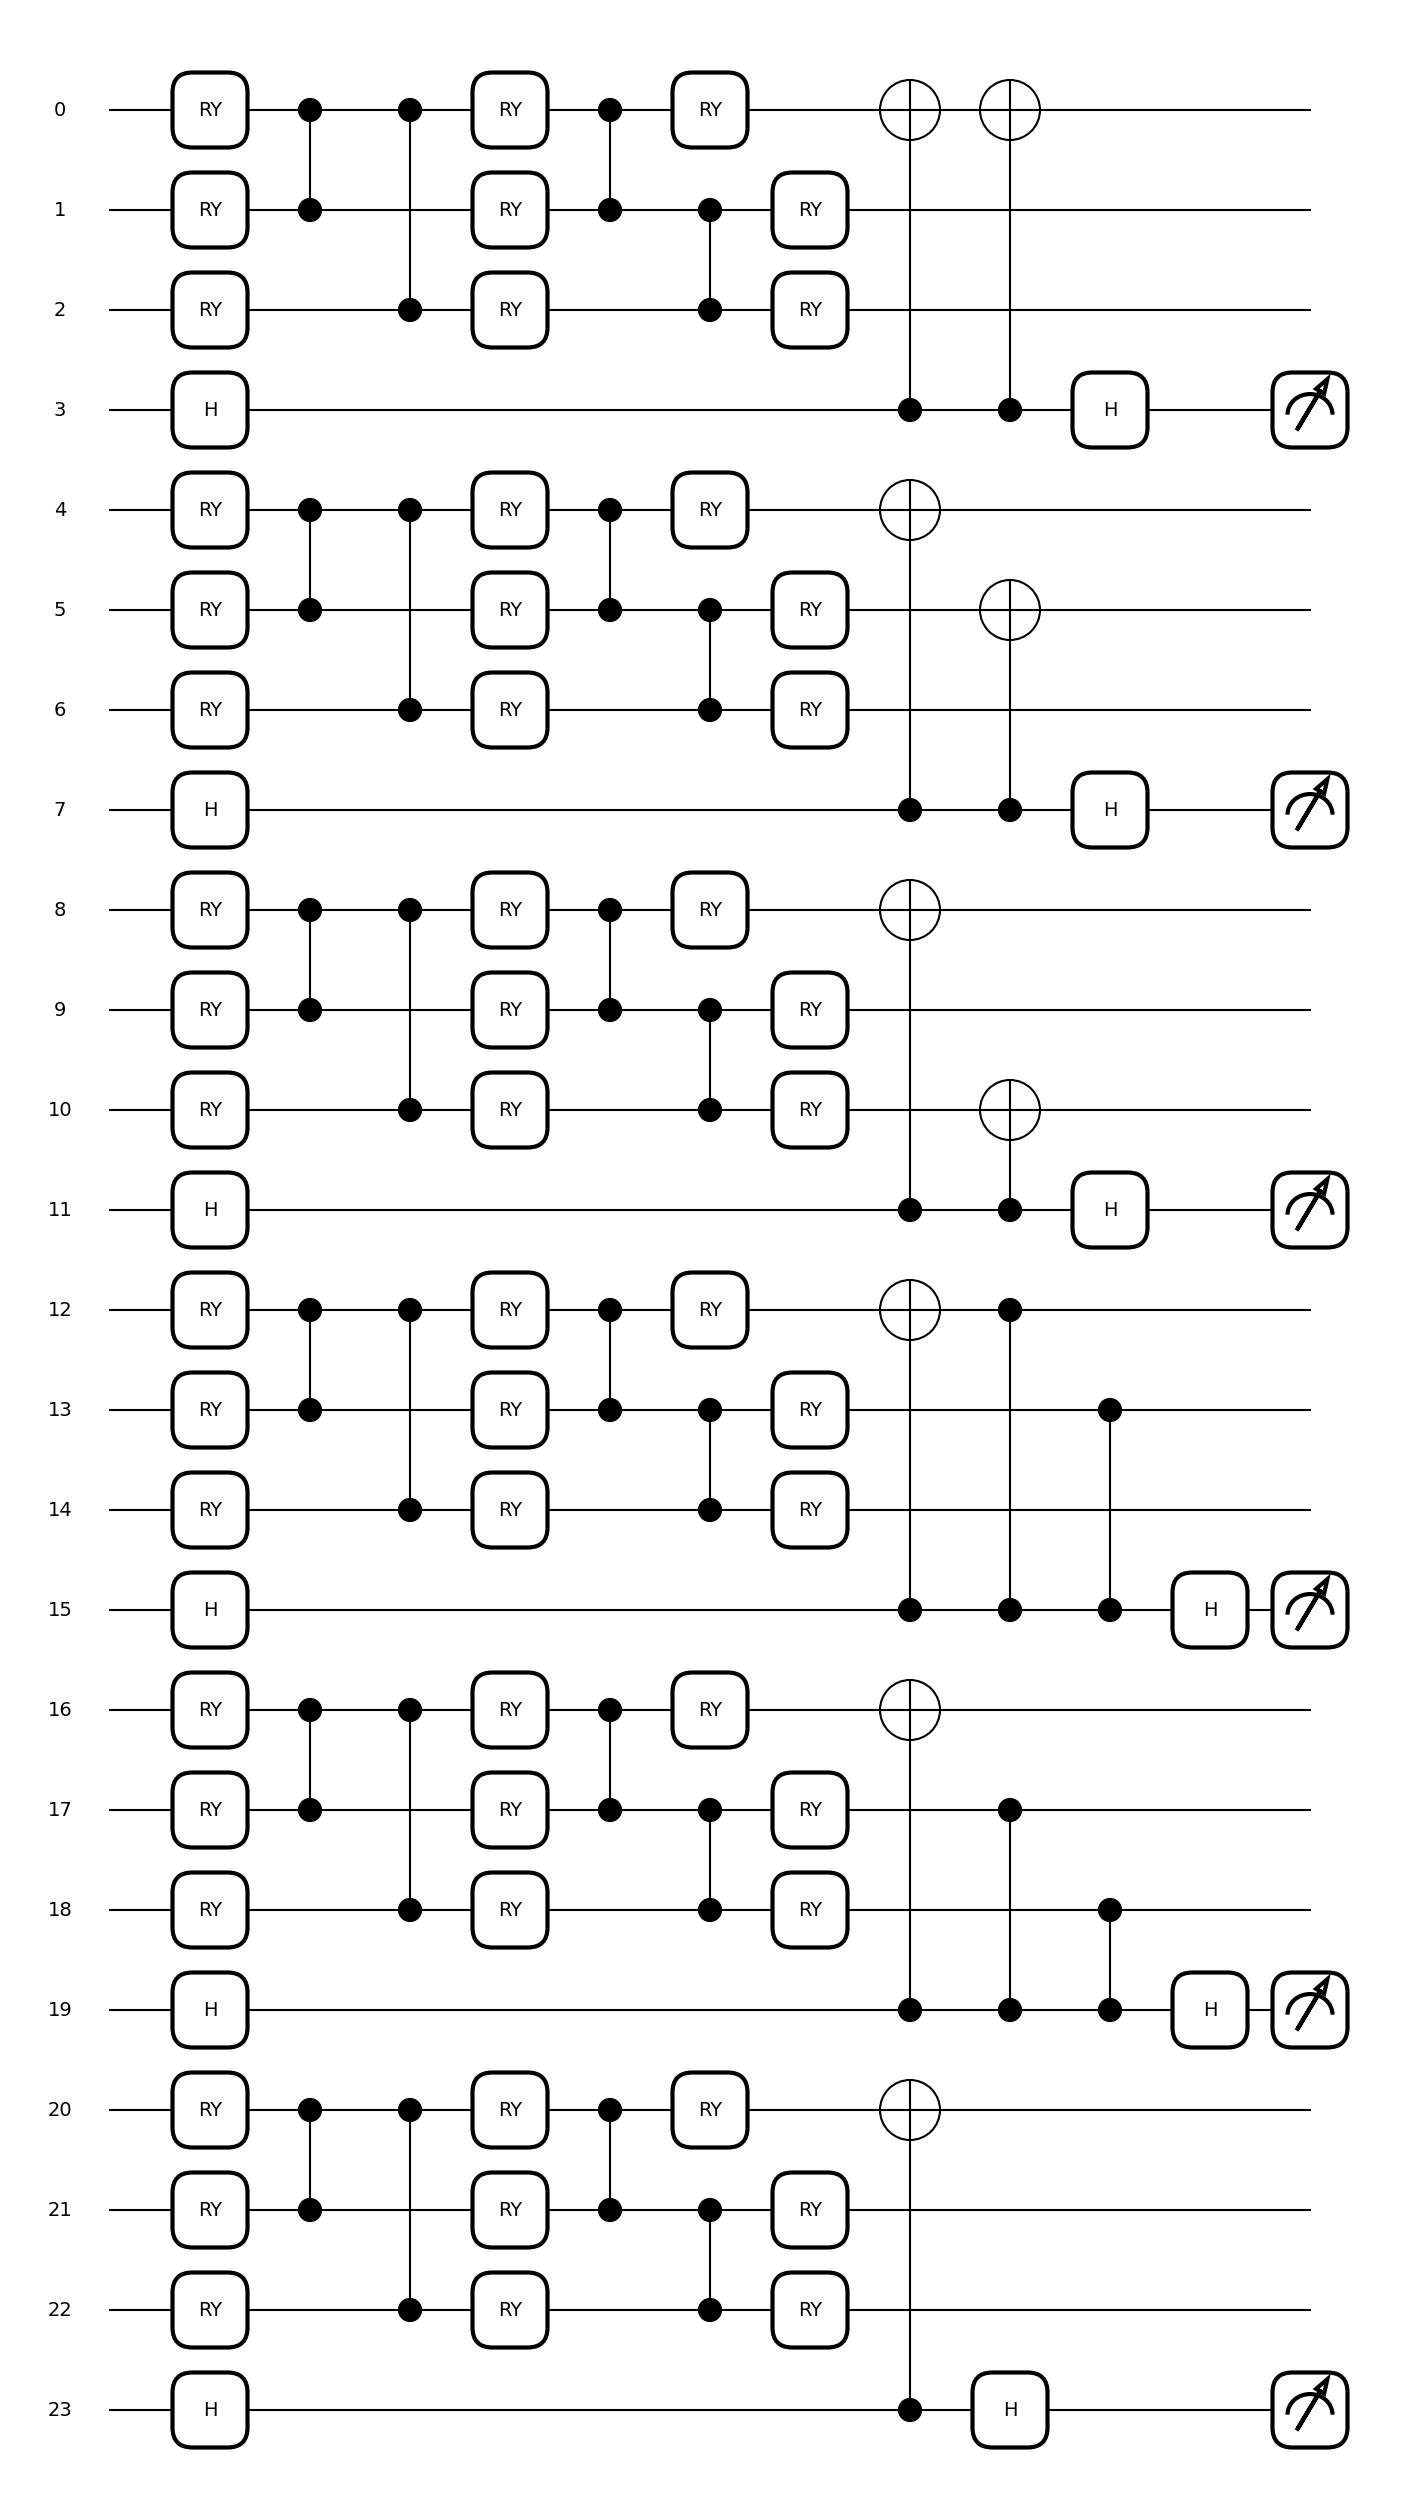

In [10]:
MAX_ITER = 500

opt = []
opt += [qml.GradientDescentOptimizer(eta)]
opt += [qml.SPSAOptimizer(MAX_ITER)]

epsilon = 0.01

m_num = 0
cond = [100] # [20*x for x in range(1,11)] # [80, 100, 120, 140, 160, 200]
cost_history = [[] for x in range(len(cond))]
time_to_solution = []

for num in range(len(cond)):

    cond_num = cond[num]

    gamma = (epsilon**2)/(n_qubits * (cond_num**2))

    for it in range(10000):
        it += 1
        w, cost = opt[0].step_and_cost(cost_loc, w)
        print("Step {:3d}       Cost = {:9.7f}".format(it, cost))
        cost_history[num].append(cost)

        if cost < gamma:
            print("Converged")
            time_to_solution += [it]
            break